# Spectral analysis

## Creating the matrix

In [1]:
import pyedflib
import numpy as np

def signal_matrix_from_eeg(filename):
    """
    A method to obtain the (k, N) data point matrix of signals using the pyedflib package.
    Args:
        *filename*: str
            The filename to open.
    Returns:
        *sigbufs*: np.array
            A (k, N) matrix representing k channels and N samples.
        *frequency*: int
            The sample frequency of the given data.
        *signal_labels*: [str]
            The channel labels of the given data.
    References:
    .. [1] The PyEDFlib package. To read EDF+/BDF+ files.
           http://pyedflib.readthedocs.io/en/latest/#
    """
    f = pyedflib.EdfReader(filename)
    
    k, N = f.signals_in_file, f.getNSamples()[0]
    
    sigbufs = np.zeros((k, N, 1))
    for i in np.arange(k):
        sigbufs[i, :, 0] = f.readSignal(i)
        
    return sigbufs, f.getSampleFrequency(0), f.getSignalLabels()

In [36]:
signal_open, frequency_open, names_open = signal_matrix_from_eeg(filename='../0. Dataset/eeg_data/S038R01.edf')
signal_closed, frequency_closed, names_closed = signal_matrix_from_eeg(filename='../0. Dataset/eeg_data/S038R02.edf')

## Using Welsh method for Power Spectral Density

In [55]:
import matplotlib.pyplot as plt
from scipy import signal

def plot_psd_welch(signals, frequency, indexes, title, nps=160):
    for i in indexes:
        f, Pxx_den = signal.welch(x=signals[i, :, 0], fs=frequency, nperseg=nps)
        plt.semilogy(f, Pxx_den)
    plt.title(title)
    plt.grid()
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.show()

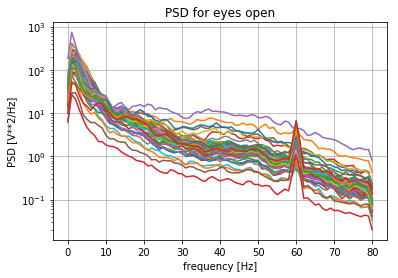

In [56]:
plot_psd_welch(signals=signal_open, frequency=160, title="PSD for eyes open", indexes=range(64))

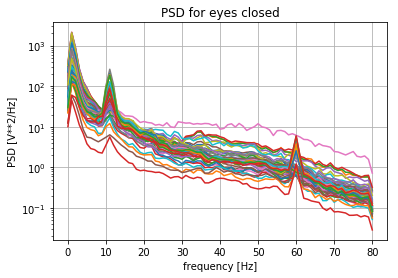

In [57]:
plot_psd_welch(signals=signal_closed, frequency=160, title="PSD for eyes closed", indexes=range(64))

As we can see, there's a peak around 10 Hz in the plot of the eyes closed experiment. The rhythm related to this frequency is the Alpha rhythm (in the band 8-13 Hz). According to the EEG analysis of channels, we should select a channel from the occipital lobe as the alpha rhythm is predominatly originated in this area. 

## Selecting relevant channel

To analyze which channels are from the occipital lobe, we checked the documentation of the [EEG files](https://physionet.org/physiobank/database/eegmmidb/) and we know that:

1. The letters F, T, C, P and O stand for frontal, temporal, central, parietal, and occipital lobes, respectively.
1. A "z" refers to an electrode placed on the midline.
1. Even numbers (2,4,6,8) refer to electrode positions on the right hemisphere, whereas odd numbers (1,3,5,7) refer to those on the left hemisphere.

Therefore, we need all channels with an O in the identifier. We have then two options to select the channels. 

1. Selecting manually the identifiers seeing the following picture:
    ![Occipital lobes channels](img/O_zone.png)
    Therefore, we know that the channels are in names and numbers respectively:
    - $PO_7$, $PO_3$, $PO_z$, $PO_4$, $PO_8$, $O_1$, $O_z$, $O_2$.
    - [55, 62] (Remember that the identifiers from the picture are from 1 to 64). 
1. Filtering the object **names_closed** selecting those indexes with an 'O' or 'o' in the channel name.

We will now follow this three steps to select the relevant channel:

1. Select the signals with O's identifiers.
1. Plot this signals and plot the complement signals to compare results.
1. Finally, if the behaviour of 1. is as expected, select the channel that maximizes the PSD in the band 8-13 Hz.

### Selecting O's identifiers

Even though we know the identifiers, let's check that we're correct selecting those identifiers with an 'o' in the channel name:

In [ ]:
occipital_lobe = list(idx for idx, names in enumerate(names_closed) if 'o' in names.lower())
rest_of_channels = list(set(range(64)).difference(set(occipital_lobe)))

### Plot the signals in occipital lobe and complement

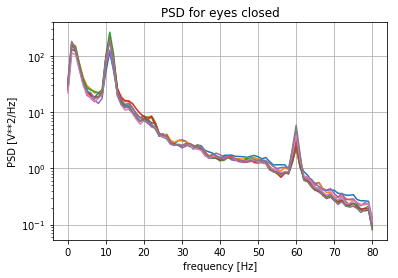

In [58]:
plot_psd_welch(signals=signal_closed, frequency=160, title="PSD for eyes closed", indexes=occipital_lobe)

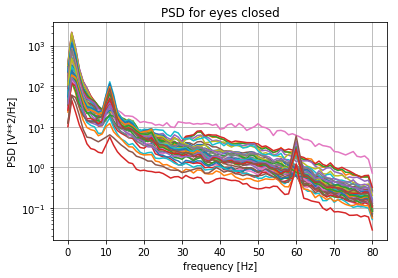

In [59]:
plot_psd_welch(signals=signal_closed, frequency=160, title="PSD for eyes closed", indexes=rest_of_channels)

### Selecting the relevant channel

We now select the channel that maximixes PSD in the occipital lobe identifiers in the range [8-13] Hz.

In [ ]:
def select_relevant_channel(signals, frequency, indexes):
    